In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [27]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.engine import engine
from quetzal.io import excel
from quetzal.os.parallel_call import parallel_call_notebook

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the road network
## Needs the road network

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
sm = stepmodel.read_json(input_path + 'de_road_network')
try:
    ae = stepmodel.read_json(model_path + 'de_road_access_egress')
except FileNotFoundError:
    ae = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_road_access_egress')
try:
    z = stepmodel.read_json(model_path + 'de_zones')
except FileNotFoundError:
    z = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_zones')

In [7]:
sm.zone_to_road = ae.zone_to_road
sm.centroids = gpd.GeoDataFrame(ae.centroids)
sm.zones = gpd.GeoDataFrame(z.zones)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
sm.road_nodes = gpd.GeoDataFrame(sm.road_nodes)

In [8]:
sm.zone_to_road.sample()

,a,b,distance,direction,speed,time,geometry
index,,,,,,,
1856,82365007,130049864,0,access,5,0,"LINESTRING (8.78944 48.80854, 8.78675 48.81132)"


In [9]:
sm.zones.index = sm.zones.index.astype(str)
sm.centroids.index = sm.centroids.index.astype(str)

## Generate LoS attribute time
The maxspeed column is based on OSM data that needs to be refined. The unit is km/h

In [10]:
# Road types
sm.road_links['highway'].unique()

array(['motorway_link', 'motorway', 'primary', 'trunk', 'trunk_link',
       'primary_link', 'secondary', 'secondary_link', 'car_train'],
      dtype=object)

array([[<Axes: title={'center': 'maxspeed'}>]], dtype=object)

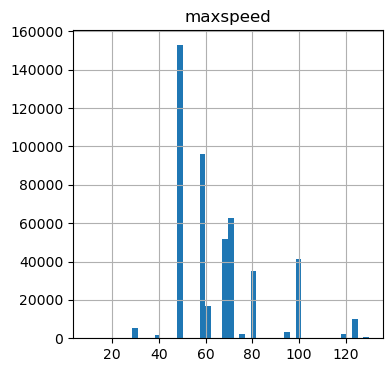

In [11]:
# Number of links (not length) with specified speeds
sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [12]:
sm.road_links['maxspeed'].unique()

array([ 81.        ,  76.        ,  70.        ,  60.        ,
       125.        , 100.        ,  68.        ,  58.        ,
        80.        ,  50.        , 120.        ,  40.        ,
        96.        ,  30.        , 130.        ,  90.        ,
        10.        ,  20.        ,  65.        ,   9.16666667])

In [13]:
# Find road nodes in cities
urban_zones = sm.zones.loc[sm.zones['urbanisation']==1, 'geometry']
urban_nodes = []
for geo in tqdm(urban_zones, total=len(urban_zones)):
    urban_nodes.append(list(set(sm.road_nodes.loc[sm.road_nodes['geometry'].within(geo)].index)))
# Flatten the list of road nodes in cities
urban_nodes = [item for sublist in urban_nodes for item in sublist]

100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:16<00:00, 12.93it/s]


In [14]:
# Set maximum speed limit for urban roads
mask_urban = (sm.road_links['a'].isin(urban_nodes)) & \
             (sm.road_links['b'].isin(urban_nodes)) & \
             (sm.road_links['highway'].isin(['primary', 'primary_link', 'secondary', 'secondary_link']))
sm.road_links.loc[mask_urban, 'maxspeed'].clip(upper=params['speed_limit']['urban'],
                                               inplace=True)

In [15]:
# Set maximum speed limit for motorways
mask_motorway = (sm.road_links['highway'].isin(['motorway_link', 'motorway', 'trunk', 'trunk_link']))
sm.road_links.loc[mask_motorway, 'maxspeed'].clip(upper=params['speed_limit']['motorways'],
                                                  inplace=True)

In [16]:
# Set maximum speed limit for other roads
sm.road_links.loc[~mask_urban & ~mask_motorway, 'maxspeed'].clip(upper=params['speed_limit']['other'],
                                                                 inplace=True)

Now, generate travel time based on the information available. In many transport models, time depends on the network flow. As a simplification for this long-term strategic model in times of modern traffic management, we assume speed limits to be equilibrated with the traffic situation. Hence, travel time depends on speed limits.

In a [publication by the Federal Environmental Agency](https://www.umweltbundesamt.de/publikationen/klimaschutz-durch-tempolimit), the following average speeds were found on the respective road sections:
- Speed limit | average traffic flow speed 
- <=60 | 60
- 80 | 87.4
- 100 | 103.3
- 120 | 115.6
- 130 | 118.3
- open | 124.7

The following calculations approximate these figures.

In [17]:
# Generate time for road links in seconds
# Manual calibration with Google maps (see below)
# shows that traffic flow is slower than the speed limits

# For up to 60km/h average speed equals the speed limit
mask60 = sm.road_links['maxspeed']<=60
sm.road_links.loc[mask60, 'time'] = sm.road_links['length'] / 1000 \
    / sm.road_links['maxspeed'] * 3600

# Then, up to under 100km/h, average speeds are 10% above the speed limit
mask100 = sm.road_links['maxspeed']<100
sm.road_links.loc[(~mask60)&(mask100), 'time'] = \
    sm.road_links['length'] / 1000 / sm.road_links['maxspeed'] * 3600 * 1.1

# Then, speed follows a polynomial of y = -0,0115x2 + 3,145x - 96,2 (R^2=1)
mask_not_open = sm.road_links['maxspeed']!=125
sm.road_links.loc[(~mask100)&(mask_not_open), 'time'] = sm.road_links['length'] / 1000 / \
    (-0.0115*np.power(sm.road_links['maxspeed'], 2) + 3.145*sm.road_links['maxspeed'] - 96.2) * 3600

# without speed limit
sm.road_links.loc[~mask_not_open, 'time'] = sm.road_links['length'] / 1000 \
    / sm.road_links['maxspeed'] * 3600

assert len(sm.road_links[sm.road_links['time'].isna()])==0
sm.road_links.loc[sm.road_links['time']==0, 'time'] = 1

<Axes: >

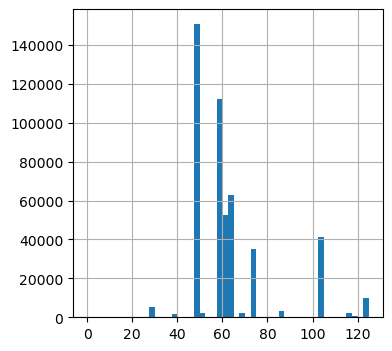

In [18]:
# Average speed by number of links (not length)
(sm.road_links['length'] / 1000 / sm.road_links['time'] * 3600).hist(bins=50, figsize=(4,4))

In [19]:
sm.road_links.sample(2)

,a,b,length,maxspeed,lanes,highway,geometry,ref,time
index,,,,,,,,,
rl_210358,1479145126,1588967505,288,81.0,1,motorway_link,"LINESTRING (8.44872 49.00317, 8.45085 49.00337)",None,14.080000
rl_410378,409154095,21724534,950,58.0,6,secondary,"LINESTRING (10.04177 53.57940, 10.05566 53.57980)",None,58.965517


## Correct road access/egress links

In [20]:
# Find missing connectors
missing_connectors = set(sm.zones.index) - set(sm.zone_to_road['a'])
islands = ['10545459', '10545488', '10560025',
           '34520013', '34529501', '34550021', '34570002']
missing_connectors - set(islands)

{'145230030', '33575407', '91809451'}

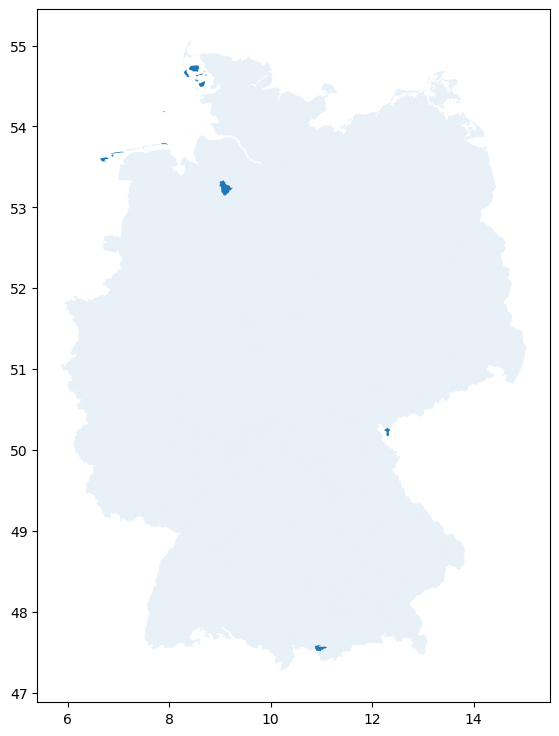

In [21]:
if manual:
    sm.zones.loc[list(missing_connectors), 'geometry'
                ].plot(ax=sm.zones.plot(alpha=0.1, figsize=(16,9)))

In [22]:
# Add missing connectors
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids.loc[list(missing_connectors - set(islands))],
    sm.road_nodes,
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=1,
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_road = pd.concat([
    sm.zone_to_road,
    ntlegs[list(set(sm.zone_to_road.columns).intersection(set(ntlegs.columns)))]]
).reset_index(drop=True)

In [23]:
# Drop island road connections (except Sylt) and connect
# them to a virtual single road node
sm.zone_to_road = sm.zone_to_road.loc[~(sm.zone_to_road['a'].isin(islands))
                                      & ~(sm.zone_to_road['b'].isin(islands))]
for i in islands:
    road_node = gpd.GeoDataFrame(index=[i+'_n'],
                                 geometry=[sm.centroids.loc[i, 'geometry']],
                                 crs=sm.epsg)
    ntlegs = engine.ntlegs_from_centroids_and_nodes(
        sm.centroids.loc[[i]],
        road_node,
        short_leg_speed=params['pt_access']['speed_walk'],
        long_leg_speed=params['pt_access']['speed_bicycle'],
        threshold=params['pt_access']['catchment_radius_walk'],
        n_neighbors=1,
        coordinates_unit=sm.coordinates_unit)
    sm.zone_to_road = pd.concat([
        sm.zone_to_road,
        ntlegs[list(set(sm.zone_to_road.columns).intersection(ntlegs.columns))]]
    ).reset_index(drop=True)
    sm.road_nodes = pd.concat([sm.road_nodes,road_node])

In [24]:
# Every zone must be connected
assert len(sm.zone_to_road.loc[sm.zone_to_road['direction']=='access','a'
                              ].unique()) == len(sm.zones.index)

In [25]:
# Assign a time by urbanisation degree
for u in sm.zones['urbanisation'].unique():
    u_zones = sm.zones.loc[sm.zones['urbanisation']==u].index
    sm.zone_to_road.loc[(sm.zone_to_road['a'].isin(u_zones)) | sm.zone_to_road['b'].isin(u_zones),
                        'time'] = params['access-egress_links']['time_road_'+str(u)]

## Apply road pathfinder to generate LoS table

In [29]:
# Load the scenario's OD set or generate it, if required
od_set = None
try:
    od_set = json.load(open(model_path + 'od_set.json'))
    od_set = set([(str(o), str(d)) for (o,d) in od_set])
    print('Found OD set with {} pairs'.format(len(od_set)))
except FileNotFoundError:
    # Generate a new one, if required
    if params['general']['od_sparse_sample'] > 0 and not scenario.endswith('equilibrium'):
        print('Generating OD set')
        kwargs = {'workers':1, 'errout_suffix':True, 'sleep':1,'stdout_path':r'log/out.txt', 'stderr_path':r'log/err.txt'}
        parallel_call_notebook('sparsify_od_set.ipynb', arg_list=[scenario], **kwargs)
        od_set = json.load(open(model_path + 'od_set.json'))
        od_set = set([(str(o), str(d)) for (o,d) in od_set])
        print('Found OD set with {} pairs'.format(len(od_set)))
    else:
        print('Running the pathfinder with full OD set')

Generating OD set
0 sparsify_od_set.py base
106 seconds
Found OD set with 263004 pairs


In [30]:
# reindex road nodes to avoid confusion with zone IDs
sm.road_nodes.index = ['n'+i for i in sm.road_nodes.index]
sm.road_links['a'] = ['n'+i for i in sm.road_links['a']]
sm.road_links['b'] = ['n'+i for i in sm.road_links['b']]
mask = sm.zone_to_road['direction']=='access'
sm.zone_to_road.loc[mask, 'b'] = ['n'+i for i in sm.zone_to_road.loc[mask, 'b']]
mask = sm.zone_to_road['direction']=='eggress'
sm.zone_to_road.loc[mask, 'a'] = ['n'+i for i in sm.zone_to_road.loc[mask, 'a']]

In [31]:
# drop duplicated links
sm.road_links = sm.road_links.loc[~sm.road_links.duplicated(['a', 'b'])]

In [37]:
sm.step_road_pathfinder(method='aon',
                        od_set=od_set)

self.volumes does not exist. od generated with self.zones


In [38]:
sm.car_los.sample()

,origin,destination,time,path,gtime,node_path,link_path,ntlegs
247599,57700020,34590024,2074.163757,"[57700020, n3844387449, n146992192, n137210971...",2074.163757,"[n3844387449, n146992192, n1372109715, n798697...","[rl_240823, rl_238603, rl_239879, rl_238452, r...","[(57700020, n3844387449), (n255950415, 34590024)]"


In [39]:
# Drop inner-cell connections
sm.car_los = sm.car_los[sm.car_los['origin']!=sm.car_los['destination']]
sm.car_los.shape

(263004, 8)

In [40]:
# Drop non-existent island connections
sm.car_los = sm.car_los.drop(sm.car_los.loc[(sm.car_los['time']==np.inf)].index)
len(sm.car_los)

262230

In [41]:
# Drop zone-to-zone connections without using the road, just access and egress links
sm.car_los = sm.car_los.loc[sm.car_los['link_path'].apply(lambda l: len(l)>0)]
len(sm.car_los)

262136

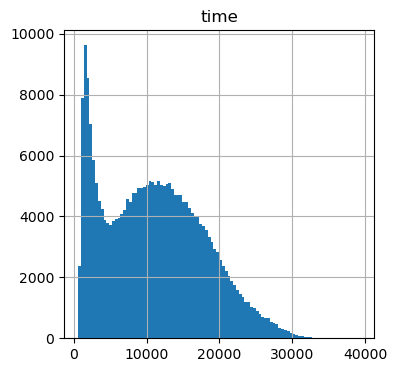

In [42]:
if manual: sm.car_los.hist(column='time', bins=100, figsize=(4,4))

## Add various attributes to LoS table

In [43]:
sm.analysis_car_los()

In [44]:
# Disaggregate into in-vehicle time and access/egress
sm.car_los['access_time'] = sm.car_los['origin'].map(
    sm.zone_to_road.drop_duplicates('a').set_index('a')['time'])
sm.car_los['in_vehicle_time'] = sm.car_los['time'] - sm.car_los['access_time']

In [45]:
# Add distances car
if not 'length' in sm.road_links.columns:
    sm.road_links['length'] = skims.distance_from_geometry(sm.road_links['geometry']).astype(int)
len_dict = sm.road_links['length'].to_dict()
sm.car_los['length'] = sm.car_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [46]:
# Add route_type = 'car' in car_los
sm.car_los['route_type'] = 'car'
sm.car_los['route_types'] = [(t,) for t in sm.car_los['route_type']]

In [47]:
#sm.car_los['ntransfers'] = 0

## Save model

In [48]:
# Ditch unneccessary columns
to_drop = ['alighting_links','alightings','all_walk','boarding_links','boardings',
           'footpaths','length_link_path','node_path','ntlegs','time_link_path','transfers',
           'pathfinder_session','gtime','reversed', 'broken_modes', 'path']
sm.car_los = sm.car_los.drop(to_drop, axis=1, errors='ignore')

In [49]:
sm.car_los.columns

Index(['origin', 'destination', 'time', 'link_path', 'access_time',
       'in_vehicle_time', 'length', 'route_type', 'route_types'],
      dtype='object')

In [50]:
assert sm.car_los.isna().any(axis=1).max() == 0

In [51]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [52]:
sm.to_zippedpickles(model_path + 'de_road_los', only_attributes=['car_los'])

car_los: 100%|█████████████████████████████████████████████████████████████████████████| 13/13 [00:43<00:00,  3.38s/it]


In [53]:
# Save distances between centroids
if params['general']['od_sparse_sample'] == 0 \
        or not os.path.exists(output_path + 'distances_centroids.csv'):
    (sm.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
    ).astype(int).to_csv(output_path + 'distances_centroids.csv')